## Normal Run

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nlm_synth.monte_carlo import run_experiments
from nlm_synth.visualize import plot_metric_by_scale

In [16]:
#synthetic bi-modal NDVI mixture (demo)
rng = np.random.default_rng(123)
veg = rng.normal(0.7, 0.08, size=50_000)
soil = rng.normal(0.2, 0.09, size=30_000)
samples = np.clip(np.hstack([veg, soil]), -0.2, 1.0)

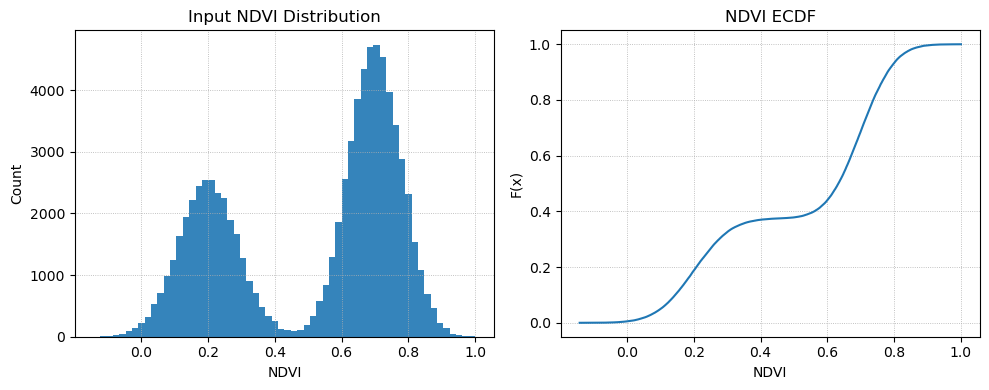

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Histogram (marginal NDVI)
ax[0].hist(samples, bins=60, edgecolor='none', alpha=0.9)
ax[0].set_title('Input NDVI Distribution')
ax[0].set_xlabel('NDVI')
ax[0].set_ylabel('Count')
ax[0].grid(True, ls=':', lw=0.6)

# ECDF
srt = np.sort(samples)
y = np.linspace(0, 1, len(srt), endpoint=False)
ax[1].plot(srt, y, lw=1.5)
ax[1].set_title('NDVI ECDF')
ax[1].set_xlabel('NDVI')
ax[1].set_ylabel('F(x)')
ax[1].grid(True, ls=':', lw=0.6)

plt.tight_layout()
plt.show()

In [18]:
generator_grid = [
    {'label': 'perlin_LF', 'method': 'perlin',
     'method_kwargs': dict(periods=(2,2), octaves=3, lacunarity=2, persistence=0.7)},
    {'label': 'perlin_MF', 'method': 'perlin',
     'method_kwargs': dict(periods=(4,4), octaves=5, lacunarity=2, persistence=0.6)},
    {'label': 'perlin_HF', 'method': 'perlin',
     'method_kwargs': dict(periods=(8,8), octaves=6, lacunarity=2, persistence=0.5)},
    {'label': 'cluster_nn', 'method': 'cluster',
     'method_kwargs': dict(p=0.55, nn_prob=0.65, periods=(6,6), octaves=2, lacunarity=2, persistence=0.4)},
]

df, meta = run_experiments(samples,
                           nrow=512, ncol=512,
                           generator_grid=generator_grid,
                           coarsen_factors=(1,2,4,8,16,32),
                           n_runs=10, semivar=False, random_seed=44)

In [19]:
df.to_csv('results_mc.csv', index=False)
print('Saved results to results_mc.csv')
print(df.head())

Saved results to results_mc.csv
       mean  variance   std_dev  morans_I       n  shape_r  shape_c  run  \
0  0.481281  0.046372  0.215341  0.999792  262144      512      512    0   
1  0.481281  0.046345  0.215279  0.998756   65536      256      256    0   
2  0.481281  0.046254  0.215067  0.994857   16384      128      128    0   
3  0.481281  0.045959  0.214381  0.981796    4096       64       64    0   
4  0.481281  0.045009  0.212154  0.942993    1024       32       32    0   

       label  method  factor  pixel_size_rel  
0  perlin_LF  perlin       1             1.0  
1  perlin_LF  perlin       2             2.0  
2  perlin_LF  perlin       4             4.0  
3  perlin_LF  perlin       8             8.0  
4  perlin_LF  perlin      16            16.0  


In [20]:
from nlm_synth.generators import perlin_field, rank_map_to_distribution

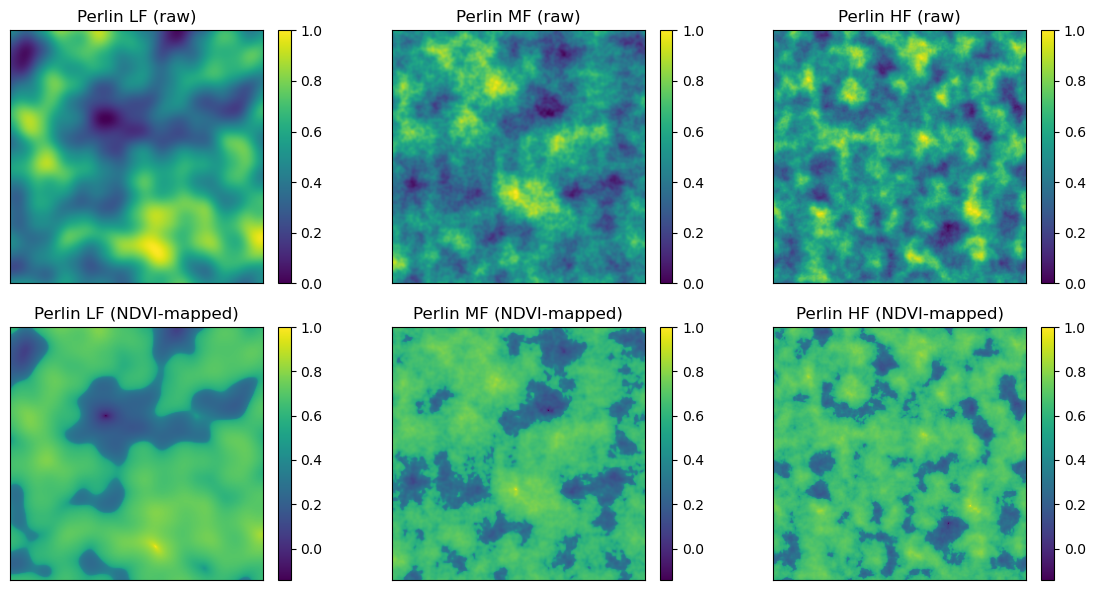

In [26]:
vis_n = 256  # smaller view for quick plotting
perlin_cfgs = [
    ('Perlin LF', dict(periods=(2,2),  octaves=3, lacunarity=2, persistence=0.7, seed=1)),
    ('Perlin MF', dict(periods=(4,4),  octaves=5, lacunarity=2, persistence=0.6, seed=2)),
    ('Perlin HF', dict(periods=(8,8),  octaves=6, lacunarity=2, persistence=0.5, seed=3)),
]

# Build figure: top row = raw Perlin (0..1), bottom row = NDVI-mapped via rank mapping
fig, axes = plt.subplots(2, len(perlin_cfgs), figsize=(4*len(perlin_cfgs), 6))

for j, (title, kwargs) in enumerate(perlin_cfgs):
    fld01 = perlin_field(vis_n, vis_n, **kwargs)  # raw 0..1 field
    mapped = rank_map_to_distribution(fld01, samples)  # NDVI-mapped

    im0 = axes[0, j].imshow(fld01, origin='upper')
    axes[0, j].set_title(f'{title} (raw)')
    axes[0, j].set_xticks([]); axes[0, j].set_yticks([])
    fig.colorbar(im0, ax=axes[0, j], fraction=0.046, pad=0.04)

    im1 = axes[1, j].imshow(mapped, origin='upper')
    axes[1, j].set_title(f'{title} (NDVI-mapped)')
    axes[1, j].set_xticks([]); axes[1, j].set_yticks([])
    fig.colorbar(im1, ax=axes[1, j], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

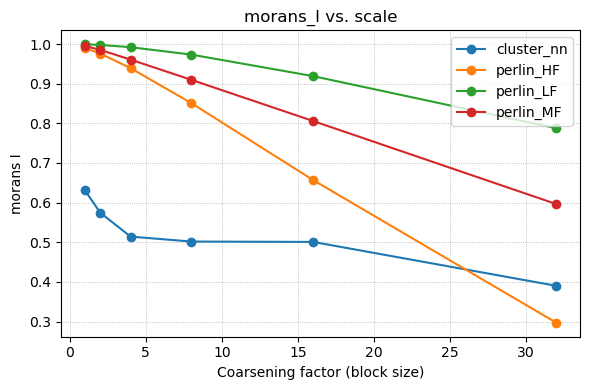

In [22]:
plot_metric_by_scale(df, metric='morans_I', by='label')
plt.savefig('moransI_vs_scale.png', dpi=150)

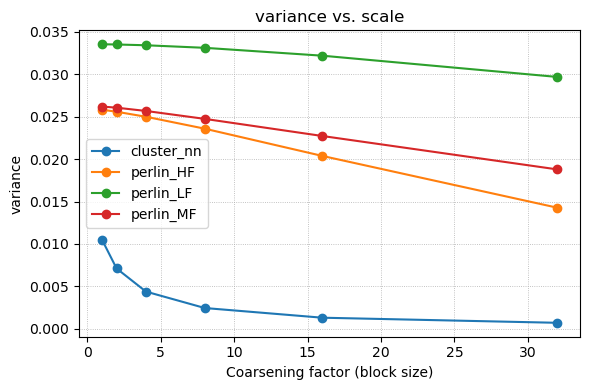

In [23]:
plot_metric_by_scale(df, metric='variance', by='label')
plt.savefig('variance_vs_scale.png', dpi=150)

## Xarray Run

In [1]:
import numpy as np
import pandas as pd
import pathlib
import sys
import importlib.util

from nlm_synth.xarray_mc import run_experiments_geotiff


In [2]:
etp_path = pathlib.Path('ETparams.py')  # e.g., Path('/absolute/path/ETparams.py')
if not etp_path.exists():
    raise FileNotFoundError(f"Could not find {etp_path.resolve()}")

spec = importlib.util.spec_from_file_location('ETparams', etp_path)
ETparams = importlib.util.module_from_spec(spec)
sys.modules['ETparams'] = ETparams
spec.loader.exec_module(ETparams)

# Create NDVI parameter and sample distribution
ndvi_param = ETparams.MixtureETParameter(
    name="NDVI",
    mu1_bounds=(0.1, 0.5),
    mu2_bounds=(0.5, 0.9),
    w1_bounds=(0.2, 0.8),
    sigma1_bounds=(0.02, 0.05),
    sigma2_bounds=(0.02, 0.05),
)

In [3]:
# Latin Hypercube to pick a parameter set (1 draw per MC run here)
ndvi_param.lhs_sample(N_samples=1)

# Choose NDVI marginal flavor: 'mixture' or 'normal'
dist_type = 'mixture'   # switch to 'normal' to compare unimodal approx
ndvi_dist = ndvi_param.create_dist(dist_type=dist_type)

# Draw many samples to define the marginal for rank-mapping
samples = np.clip(ndvi_dist.sample(100_000), -0.2, 1.0)

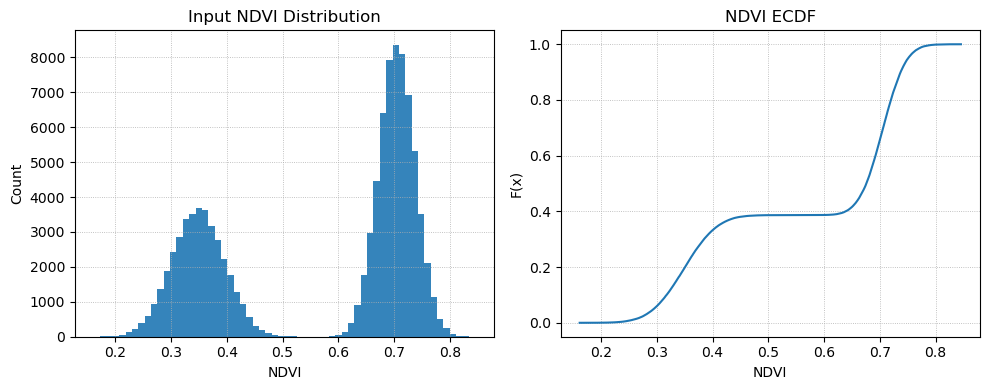

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Histogram of marginal NDVI
ax[0].hist(samples, bins=60, edgecolor='none', alpha=0.9)
ax[0].set_title('Input NDVI Distribution')
ax[0].set_xlabel('NDVI')
ax[0].set_ylabel('Count')
ax[0].grid(True, ls=':', lw=0.6)

# ECDF
srt = np.sort(samples)
y = np.linspace(0, 1, len(srt), endpoint=False)
ax[1].plot(srt, y, lw=1.5)
ax[1].set_title('NDVI ECDF')
ax[1].set_xlabel('NDVI')
ax[1].set_ylabel('F(x)')
ax[1].grid(True, ls=':', lw=0.6)

plt.tight_layout()
plt.show()

In [7]:
# ---------------------------------------------------------------------
# (B) Georeferencing settings: CRS, transform origin, pixel size
# ---------------------------------------------------------------------
# Option 1: define transform from origin + pixel size (north-up)
x0, y0 = 500_000.0, 4_000_000.0   # upper-left corner in projected coords
pixel_size = 30.0                 # meters
crs = "EPSG:32611"

In [42]:
# Option 2 (optional): derive CRS/transform from a template GeoTIFF
# import rioxarray as rxr
# tpl = rxr.open_rasterio('template.tif').squeeze()
# crs = tpl.rio.crs.to_string()
# pixel_size = tpl.rio.resolution()[0]  # assumes square pixels
# x0 = tpl.rio.transform().c
# y0 = tpl.rio.transform().f


In [8]:
# ---------------------------------------------------------------------
# (C) Run Monte Carlo with GeoTIFF outputs
# ---------------------------------------------------------------------
out_dir = 'ndvi_mc_geotiff'
df, meta = run_experiments_geotiff(
    samples=samples,
    out_dir=out_dir,
    nrow=512, ncol=512,
    pixel_size=pixel_size,
    x0=x0, y0=y0,
    crs=crs,
    generator_grid=[
        {'label': 'perlin_LF', 'method': 'perlin',
         'method_kwargs': dict(periods=(2,2), octaves=3, lacunarity=2, persistence=0.7)},
        {'label': 'perlin_HF', 'method': 'perlin',
         'method_kwargs': dict(periods=(8,8), octaves=6, lacunarity=2, persistence=0.5)},
        {'label': 'cluster_nn', 'method': 'cluster',
         'method_kwargs': dict(p=0.55, nn_prob=0.65, periods=(6,6), octaves=2, lacunarity=2, persistence=0.4)},
    ],
    coarsen_factors=(1,2,4,8,16,32),
    n_runs=5,
    random_seed=123,
    write_fullres=True,
    name_prefix=f'ndvi_{dist_type}',
)

print('Saved GeoTIFFs/results to:', out_dir)
print(df.head())

Saved GeoTIFFs/results to: ndvi_mc_geotiff
       mean  variance   std_dev  morans_I       n  shape_r  shape_c  run  \
0  0.592248  0.023311  0.152678  0.997069  262144      512      512    0   
1  0.592248  0.023245  0.152464  0.994327   65536      256      256    0   
2  0.592248  0.023116  0.152041  0.986146   16384      128      128    0   
3  0.592248  0.022802  0.151005  0.964708    4096       64       64    0   
4  0.592248  0.022089  0.148623  0.909873    1024       32       32    0   

       label  method  factor  pixel_size  nrow  ncol  
0  perlin_LF  perlin       1        30.0   512   512  
1  perlin_LF  perlin       2        60.0   256   256  
2  perlin_LF  perlin       4       120.0   128   128  
3  perlin_LF  perlin       8       240.0    64    64  
4  perlin_LF  perlin      16       480.0    32    32  


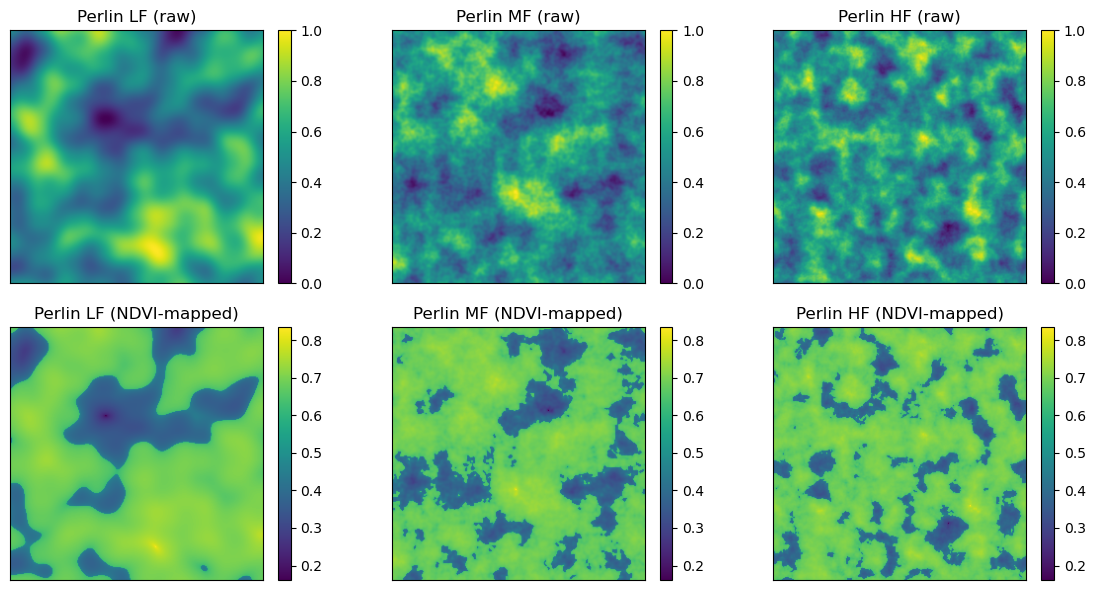

In [9]:
from nlm_synth.generators import perlin_field, rank_map_to_distribution

vis_n = 256  # smaller view for quick plotting
perlin_cfgs = [
    ('Perlin LF', dict(periods=(2,2),  octaves=3, lacunarity=2, persistence=0.7, seed=1)),
    ('Perlin MF', dict(periods=(4,4),  octaves=5, lacunarity=2, persistence=0.6, seed=2)),
    ('Perlin HF', dict(periods=(8,8),  octaves=6, lacunarity=2, persistence=0.5, seed=3)),
]

fig, axes = plt.subplots(2, len(perlin_cfgs), figsize=(4*len(perlin_cfgs), 6))

for j, (title, kwargs) in enumerate(perlin_cfgs):
    fld01 = perlin_field(vis_n, vis_n, **kwargs)  # raw 0..1 field
    mapped = rank_map_to_distribution(fld01, samples)  # NDVI-mapped

    im0 = axes[0, j].imshow(fld01, origin='upper')
    axes[0, j].set_title(f'{title} (raw)')
    axes[0, j].set_xticks([]); axes[0, j].set_yticks([])
    fig.colorbar(im0, ax=axes[0, j], fraction=0.046, pad=0.04)

    im1 = axes[1, j].imshow(mapped, origin='upper')
    axes[1, j].set_title(f'{title} (NDVI-mapped)')
    axes[1, j].set_xticks([]); axes[1, j].set_yticks([])
    fig.colorbar(im1, ax=axes[1, j], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [6]:
import numpy as np # version 1.21.0
from nlmpy import nlmpy # version 1.0.1
import matplotlib as mpl # version 3.2.1


In [7]:
# Define domain for data
dim = 640
x = np.linspace(0, 1, dim)

# Define the parameters that control the waves
periods = 4
octaves = 3
lacunarity = 2
persistence = 0.5

In [8]:
# Function to calculate a sine wave
def sineWave(x, periods):
    y = np.sin(x * (2 * np.pi * periods))
    return(y)

# Generate a list of sine waves and a combined noise wave
for octave in range(octaves):
    if octave == 0:
        y = sineWave(x, periods = periods)
        sineOctaves = [y]
        noiseWave = np.copy(y)
    else:
        octavePeriod = periods * (octave * lacunarity)
        y = sineWave(x, periods = octavePeriod)
        y = y * (persistence ** octave)
        sineOctaves.append(y)
        noiseWave = noiseWave + y
sineOctaves.append(noiseWave)

In [9]:
# Set random seed to get the same Fourier set
np.random.seed(7)

# Generate a list of sine waves and a combined noise wave
for octave in range(octaves):
    if octave == 0:
        y = sineWave(x, periods = 1)
        fourierOctaves = [y]
        fourierWave = np.copy(y)
    else:
        octavePeriod = 1 * (octave * lacunarity)
        y = sineWave(x + np.random.uniform(), periods = octavePeriod)
        y = y * (persistence ** octave)
        fourierOctaves.append(y)
        fourierWave = fourierWave + y
fourierOctaves.append(fourierWave)

In [10]:
# Set random seed to get the same Perlin noise
np.random.seed(2)

# Generate a list of Perlin noise surfaces and a combined Perlin noise surface
for octave in range(octaves):
    perlinOctave = nlmpy.octave(nRow = dim, nCol = dim, 
                                periods = (periods, periods),
                                persistence = persistence, 
                                octive = octave,
                                lacunarity = lacunarity)    
    if octave == 0:
        perlinOctaves = [perlinOctave]
        perlinNoise = np.copy(perlinOctave)
    else:
        perlinOctaves.append(perlinOctave)
        perlinNoise = perlinNoise + perlinOctave
perlinOctaves.append(perlinNoise)  

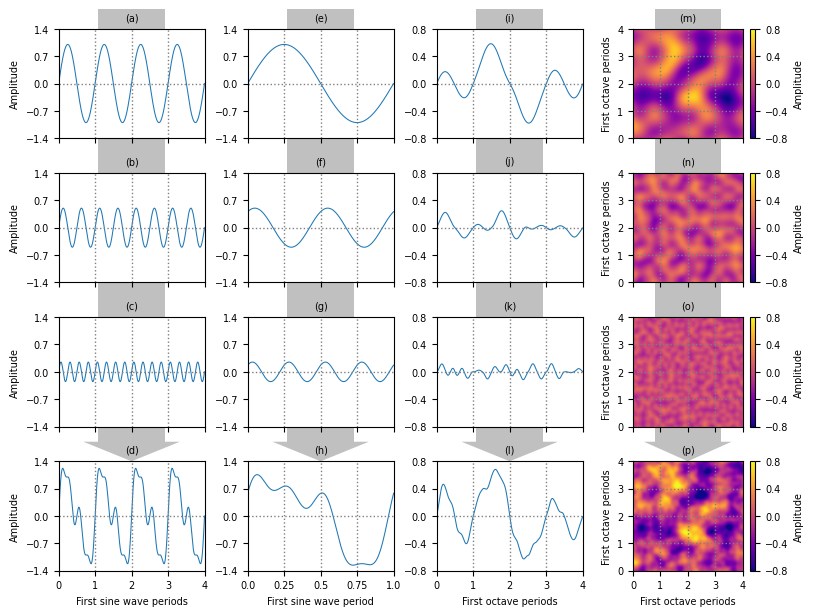

In [16]:
mpl.pyplot.rcParams.update({'font.size': 7})
fig, axes = mpl.pyplot.subplots(nrows=4, ncols=4, figsize=(8, 6)) # figsize=(width, height) in inches
panels = ["(a)", "(b)", "(c)", "(d)", 
          "(e)", "(f)", "(g)", "(h)", 
          "(i)", "(j)", "(k)", "(l)",
          "(m)", "(n)", "(o)", "(p)"]
panelcount = -1

# Plot sine waves
ylim = 1.4
for octave in range(octaves + 1):
    axsi = axes[octave][0]
    axsi.plot(x, sineOctaves[octave], lw=0.75)
    axsi.set_ylim([-ylim, ylim])
    axsi.set_xlim([0, 1])
    axsi.yaxis.set_ticks([-ylim, -(ylim/2), 0, ylim/2, ylim])
    axsi.set_ylabel("Amplitude")
    axsi.axhline(0, lw=1, c='grey', ls=":")
    for i in range(1, periods):
        axsi.axvline(i / periods, lw=1, c='grey', ls=":")
    panelcount = panelcount + 1
    axsi.set_title(panels[panelcount], fontsize=7)
    if panelcount != 3:
        axsi.xaxis.set_ticks(np.linspace(0, 1, periods + 1))
        axsi.xaxis.set_ticklabels([])
    else:
        axsi.xaxis.set_ticks(np.linspace(0, 1, periods + 1))
        axsi.xaxis.set_ticklabels([0,1,2,3,4])
        axsi.set_xlabel("First sine wave periods")
    # Plot grey arrow
    if octave in [0,1,2]:
        aX = [0.2698, 0.7301, 0.7301, 0.2698]
        aY = [ylim, ylim, ylim + 0.5, ylim + 0.5]
        axsi.fill(aX, aY, ec=None, fc='silver', clip_on=False)
        aX = [0.2698, 0.7301, 0.7301, 0.2698]
        aY = [-ylim, -ylim, -ylim - 0.4, -ylim - 0.4]
        axsi.fill(aX, aY, ec=None, fc='silver', clip_on=False)           
    else:
        aX = [0.1697, 0.5, 0.8302]
        aY = [ylim + 0.5, ylim, ylim + 0.5]
        axsi.fill(aX, aY, ec=None, fc='silver', clip_on=False)



# Plot fourier waves
ylim = 1.4
for octave in range(octaves + 1):
    axsi = axes[octave][1]
    axsi.plot(x, fourierOctaves[octave], lw=0.75)
    axsi.set_ylim([-ylim, ylim])
    axsi.set_xlim([0, 1])
    axsi.yaxis.set_ticks([-ylim, -(ylim/2), 0, ylim/2, ylim])
    axsi.set_ylabel("")
    axsi.axhline(0, lw=1, c='grey', ls=":")
    for i in range(1, periods):
        axsi.axvline(i / periods, lw=1, c='grey', ls=":")
    panelcount = panelcount + 1
    axsi.set_title(panels[panelcount], fontsize=7)
    if panelcount != 7:
        axsi.xaxis.set_ticks(np.linspace(0, 1, periods + 1))
        axsi.xaxis.set_ticklabels([])
    else:
        axsi.xaxis.set_ticks(np.linspace(0, 1, periods + 1))
        axsi.xaxis.set_ticklabels(np.linspace(0, 1, periods + 1))
        axsi.set_xlabel("First sine wave period")
    # Plot grey arrow
    if octave in [0,1,2]:
        aX = [0.2698, 0.7301, 0.7301, 0.2698]
        aY = [ylim, ylim, ylim + 0.5, ylim + 0.5]
        axsi.fill(aX, aY, ec=None, fc='silver', clip_on=False)
        aX = [0.2698, 0.7301, 0.7301, 0.2698]
        aY = [-ylim, -ylim, -ylim - 0.4, -ylim - 0.4]
        axsi.fill(aX, aY, ec=None, fc='silver', clip_on=False)           
    else:
        aX = [0.1697, 0.5, 0.8302]
        aY = [ylim + 0.5, ylim, ylim + 0.5]
        axsi.fill(aX, aY, ec=None, fc='silver', clip_on=False)



# Plot Perlin noise
ylim = 0.8
for octave in range(octaves + 1):
    # Plot a cross-section
    axsi = axes[octave][2]
    axsi.plot(x, perlinOctaves[octave][160, :], lw=0.75)
    axsi.set_ylim([-ylim, ylim])
    axsi.set_xlim([0, 1])
    axsi.xaxis.set_ticks([])
    axsi.yaxis.set_ticks([-ylim, -(ylim/2), 0, ylim/2, ylim])
    axsi.axhline(0, lw=1, c='grey', ls=":")
    for i in range(1, periods):
        axsi.axvline(i / periods, lw=1, c='grey', ls=":")
    panelcount = panelcount + 1
    axsi.set_title(panels[panelcount], fontsize=7)
    if panelcount != 11:
        axsi.xaxis.set_ticks(np.linspace(0, 1, periods + 1))
        axsi.xaxis.set_ticklabels([])
    else:
        axsi.xaxis.set_ticks(np.linspace(0, 1, periods + 1))
        axsi.xaxis.set_ticklabels([0,1,2,3,4])
        axsi.set_xlabel("First octave periods")
    # Plot grey arrow
    if octave in [0,1,2]:
        aX = [0.2698, 0.7301, 0.7301, 0.2698]
        aY = [ylim, ylim, ylim + 0.2857, ylim + 0.2857]
        axsi.fill(aX, aY, ec=None, fc='silver', clip_on=False)
        aX = [0.2698, 0.7301, 0.7301, 0.2698]
        aY = [-ylim, -ylim, -ylim - 0.2285, -ylim - 0.2285]
        axsi.fill(aX, aY, ec=None, fc='silver', clip_on=False)
    else:
        aX = [0.1697, 0.5, 0.8302]
        aY = [ylim + 0.2857, ylim, ylim + 0.2857]
        axsi.fill(aX, aY, ec=None, fc='silver', clip_on=False)    
    
    # Plot the whole surface
    axsi = axes[octave][3]
    axsi.set_ylim([0, 4])
    axsi.set_xlim([0, 4])
    im = axsi.imshow(perlinOctaves[octave], vmin=-ylim, vmax=ylim, cmap=mpl.cm.plasma, extent=[0,4,0,4])
    cbar = fig.colorbar(im, ax=axsi, orientation='vertical', ticks=[-ylim, -(ylim/2), 0, ylim/2, ylim])
    cbar.set_label("Amplitude")    
    axsi.set_ylabel("First octave periods")
    if panelcount != 11:
        axsi.xaxis.set_ticks(np.linspace(0, 4, periods + 1))
        axsi.xaxis.set_ticklabels([])
    else:
        axsi.xaxis.set_ticks(np.linspace(0, 4, periods + 1))
        axsi.xaxis.set_ticklabels([0,1,2,3,4])
        axsi.set_xlabel("First octave periods")
    axsi.set_title(panels[panelcount + 4], fontsize=7)
    
    for i in range(1, periods):
        axsi.axvline(i, lw=1, c='grey', ls=":")
        axsi.axhline(i, lw=1, c='grey', ls=":")
    # Plot grey arrow
    if octave in [0,1,2]:
        aX = [0.8, 3.2, 3.2, 0.8]
        aY = [4, 4, 4 + 0.7142, 4 + 0.7142]
        axsi.fill(aX, aY, ec=None, fc='silver', clip_on=False)
        aX = [0.8, 3.2, 3.2, 0.8]
        aY = [0, 0, 0 - 0.5714, 0 - 0.5714]
        axsi.fill(aX, aY, ec=None, fc='silver', clip_on=False)    
    else:
        aX = [0.4, 2.0, 3.6]
        aY = [4 + 0.7142, 4, 4 + 0.7142]
        axsi.fill(aX, aY, ec=None, fc='silver', clip_on=False)
mpl.pyplot.tight_layout(pad=0.25)
plt.show()    

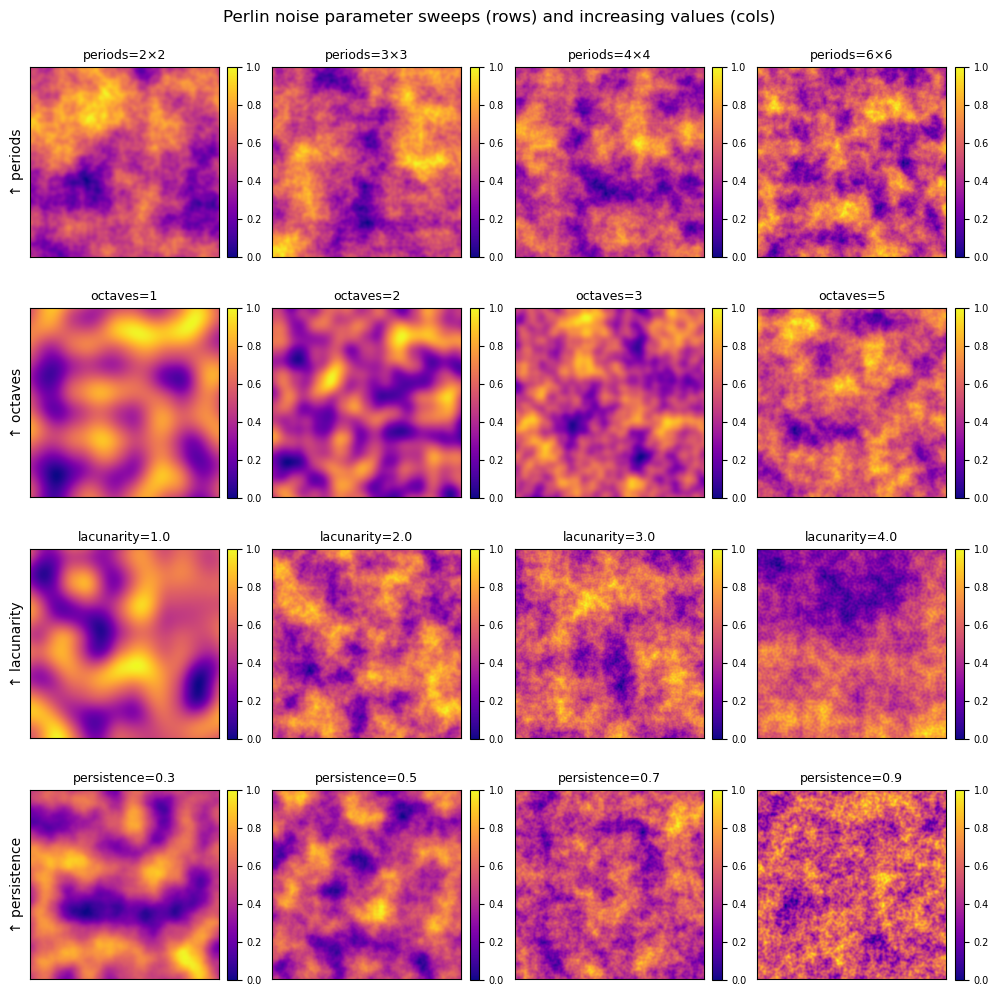

In [20]:
# ============================================================
# Perlin parameter sweeps (4x4 figure)
# Rows: periods / octaves / lacunarity / persistence
# Cols: increasing values within that parameter
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
from nlm_synth.generators import perlin_field

# ---- Figure config ----
vis_n = 256                 # preview size
seed_base = 2025            # base seed so panels are reproducible
cmap = 'plasma'             # similar to template; change if you prefer

# ---- Baseline (held constant except the row being swept) ----
BASE_PERIODS    = (4, 4)    # MUST be ints for NLMPy
BASE_OCTAVES    = 5
BASE_LACUNARITY = 2.0
BASE_PERSIST    = 0.6

# ---- Sweep definitions (4 columns each) ----
periods_values     = [(2,2), (3,3), (4,4), (6,6)]
octaves_values     = [1, 2, 3, 5]
lacunarity_values  = [1, 2, 3, 4]
persistence_values = [0.3, 0.5, 0.7, 0.9]

# Helper to ensure proper types for NLMPy perlinNoise
# Change this helper function
def _kw(periods=BASE_PERIODS, octaves=BASE_OCTAVES, lacunarity=BASE_LACUNARITY, persistence=BASE_PERSIST):
    p = (int(periods[0]), int(periods[1]))
    return dict(
        periods=p,
        octaves=int(octaves),
        lacunarity=int(lacunarity),  
        persistence=float(persistence)
    )

# ---- Build the 4x4 panel ----
fig, axes = plt.subplots(4, 4, figsize=(10, 10))  # similar to template's compact panel

# Row 1: periods
for j, per in enumerate(periods_values):
    kwargs = _kw(periods=per)
    fld = perlin_field(vis_n, vis_n, seed=seed_base + j, **kwargs)
    im = axes[0, j].imshow(fld, origin='upper', cmap=cmap)
    axes[0, j].set_title(f"periods={per[0]}×{per[1]}", fontsize=9)
    axes[0, j].set_xticks([]); axes[0, j].set_yticks([])
    fig.colorbar(im, ax=axes[0, j], fraction=0.046, pad=0.04)

# Row 2: octaves
for j, octv in enumerate(octaves_values):
    kwargs = _kw(octaves=octv)
    fld = perlin_field(vis_n, vis_n, seed=seed_base + 100 + j, **kwargs)
    im = axes[1, j].imshow(fld, origin='upper', cmap=cmap)
    axes[1, j].set_title(f"octaves={int(octv)}", fontsize=9)
    axes[1, j].set_xticks([]); axes[1, j].set_yticks([])
    fig.colorbar(im, ax=axes[1, j], fraction=0.046, pad=0.04)

# Row 3: lacunarity
for j, lac in enumerate(lacunarity_values):
    kwargs = _kw(lacunarity=lac)
    fld = perlin_field(vis_n, vis_n, seed=seed_base + 200 + j, **kwargs)
    im = axes[2, j].imshow(fld, origin='upper', cmap=cmap)
    axes[2, j].set_title(f"lacunarity={lac:.1f}", fontsize=9)
    axes[2, j].set_xticks([]); axes[2, j].set_yticks([])
    fig.colorbar(im, ax=axes[2, j], fraction=0.046, pad=0.04)

# Row 4: persistence
for j, pst in enumerate(persistence_values):
    kwargs = _kw(persistence=pst)
    fld = perlin_field(vis_n, vis_n, seed=seed_base + 300 + j, **kwargs)
    im = axes[3, j].imshow(fld, origin='upper', cmap=cmap)
    axes[3, j].set_title(f"persistence={pst:.1f}", fontsize=9)
    axes[3, j].set_xticks([]); axes[3, j].set_yticks([])
    fig.colorbar(im, ax=axes[3, j], fraction=0.046, pad=0.04)

# Row labels on the left
axes[0, 0].set_ylabel("↑ periods", fontsize=10)
axes[1, 0].set_ylabel("↑ octaves", fontsize=10)
axes[2, 0].set_ylabel("↑ lacunarity", fontsize=10)
axes[3, 0].set_ylabel("↑ persistence", fontsize=10)

fig.suptitle("Perlin noise parameter sweeps (rows) and increasing values (cols)", y=0.995, fontsize=12)
plt.tight_layout()
plt.savefig("perlin_parameter_sweeps.png", dpi=200)
plt.show()


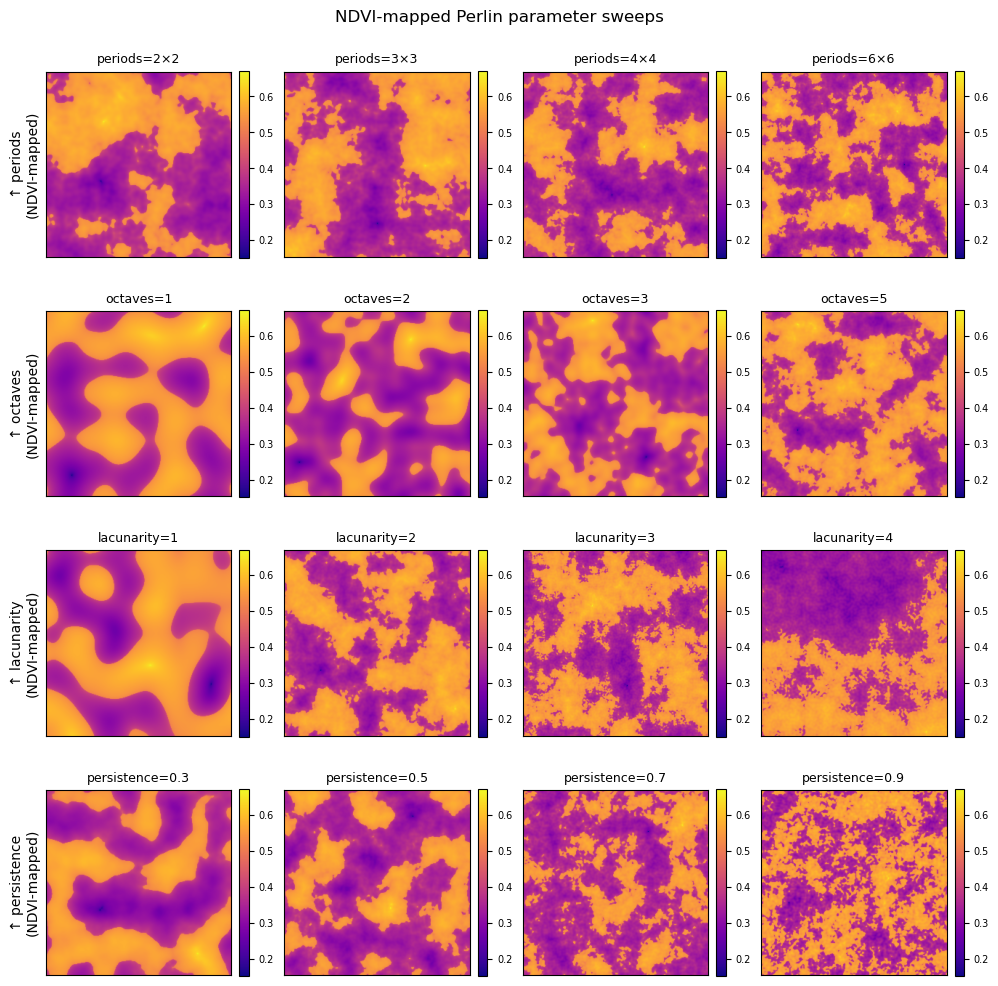

In [21]:
# ============================================================
# NDVI-mapped versions of the same 4×4 grid
# (quantile-map Perlin fields to your NDVI marginal `samples`)
# ============================================================
from nlm_synth.generators import perlin_field, rank_map_to_distribution

fig2, axes2 = plt.subplots(4, 4, figsize=(10, 10))
cmap = 'plasma'  # or choose something like 'viridis'

# Row 1: periods (NDVI-mapped)
for j, per in enumerate(periods_values):
    kwargs = _kw(periods=per)
    fld = perlin_field(vis_n, vis_n, seed=seed_base + j, **kwargs)
    ndvi_img = rank_map_to_distribution(fld, samples)
    im = axes2[0, j].imshow(ndvi_img, origin='upper', cmap=cmap)
    axes2[0, j].set_title(f"periods={per[0]}×{per[1]}", fontsize=9)
    axes2[0, j].set_xticks([]); axes2[0, j].set_yticks([])
    fig2.colorbar(im, ax=axes2[0, j], fraction=0.046, pad=0.04)

# Row 2: octaves (NDVI-mapped)
for j, octv in enumerate(octaves_values):
    kwargs = _kw(octaves=octv)
    fld = perlin_field(vis_n, vis_n, seed=seed_base + 100 + j, **kwargs)
    ndvi_img = rank_map_to_distribution(fld, samples)
    im = axes2[1, j].imshow(ndvi_img, origin='upper', cmap=cmap)
    axes2[1, j].set_title(f"octaves={int(octv)}", fontsize=9)
    axes2[1, j].set_xticks([]); axes2[1, j].set_yticks([])
    fig2.colorbar(im, ax=axes2[1, j], fraction=0.046, pad=0.04)

# Row 3: lacunarity (NDVI-mapped)
for j, lac in enumerate(lacunarity_values):
    kwargs = _kw(lacunarity=lac)  # note: lacunarity is int per your fix
    fld = perlin_field(vis_n, vis_n, seed=seed_base + 200 + j, **kwargs)
    ndvi_img = rank_map_to_distribution(fld, samples)
    im = axes2[2, j].imshow(ndvi_img, origin='upper', cmap=cmap)
    axes2[2, j].set_title(f"lacunarity={int(lac)}", fontsize=9)
    axes2[2, j].set_xticks([]); axes2[2, j].set_yticks([])
    fig2.colorbar(im, ax=axes2[2, j], fraction=0.046, pad=0.04)

# Row 4: persistence (NDVI-mapped)
for j, pst in enumerate(persistence_values):
    kwargs = _kw(persistence=pst)
    fld = perlin_field(vis_n, vis_n, seed=seed_base + 300 + j, **kwargs)
    ndvi_img = rank_map_to_distribution(fld, samples)
    im = axes2[3, j].imshow(ndvi_img, origin='upper', cmap=cmap)
    axes2[3, j].set_title(f"persistence={pst:.1f}", fontsize=9)
    axes2[3, j].set_xticks([]); axes2[3, j].set_yticks([])
    fig2.colorbar(im, ax=axes2[3, j], fraction=0.046, pad=0.04)

# Row labels for clarity
axes2[0, 0].set_ylabel("↑ periods\n(NDVI-mapped)", fontsize=10)
axes2[1, 0].set_ylabel("↑ octaves\n(NDVI-mapped)", fontsize=10)
axes2[2, 0].set_ylabel("↑ lacunarity\n(NDVI-mapped)", fontsize=10)
axes2[3, 0].set_ylabel("↑ persistence\n(NDVI-mapped)", fontsize=10)

fig2.suptitle("NDVI-mapped Perlin parameter sweeps", y=0.995, fontsize=12)
plt.tight_layout()
plt.savefig("perlin_parameter_sweeps_ndvi_mapped.png", dpi=200)
plt.show()
